# Depresión en México

## Instalación de Librerías

In [1]:
!pip install twint
!pip install nltk
!pip install spacy

In [2]:
!python -m spacy download es_core_news_sm

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


2021-06-16 19:32:11.536085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-16 19:32:11.536748: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Importación de Librerías

In [3]:
from nltk import download

In [4]:
download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lordd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import pandas as pd
import numpy as np

import twint
import nest_asyncio
from os import remove

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist

import spacy
nlp = spacy.load("es_core_news_sm")

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
import seaborn as sns
from plotly import express as px

## Funciones

### deleteDownloadedData

La función <code>deleteDownloadedData</code> permite eliminar los archivos <code>.CSV</code> que fueron utilizados por la función <code>concatenateData</code>.

Este proceso se realiza mediante la función <code>remove</code> de la librería <code>os</code>.

In [6]:
def deleteDownloadedData(data, path):
    for index in range(0, data.shape[0]):
        remove("{}/{}.csv".format(path, data["state"].iloc[index]))

### concatenateData

La función <code>concatenateData</code> realiza la lectura de los archivos <code>.CSV</code> descargados por la función <code>downloadTwitterData</code> para generar un unico documento <code>.CSV</code>.

Este proceso se realiza mediante las funciones <code>read_csv</code> y <code>concat</code> de la librería <code>pandas</code>.

In [7]:
def concatenateData(data, path):
    twitter = pd.read_csv("{}/{}.csv".format(path, data["state"].iloc[0]), index_col=0)
    for index in range(1, data.shape[0]):
        tweets = pd.read_csv("{}/{}.csv".format(path, data["state"].iloc[index]), index_col=0)
        twitter = pd.concat([twitter, tweets])
    twitter.to_csv("{}/twitter-raw.csv".format(path), index=False)
    deleteDownloadedData(data, path)

### downloadTwitterData

La función <code>downloadTwitterData</code> permite descargar en formato <code>.CSV</code> una determinada cantidad de publicaciones de Twitter realizadas en una ubicación y rango determinados.

Este proceso se realiza mediante la función <code>Search</code> de la librería <code>twint</code>.

In [8]:
def downloadTwitterData(data, path, kilometers=10, limit=16000):
    for index in range(0, data.shape[0]):

        state, longitude, latitude = data.iloc[index]

        c = twint.Config()
        c.Geo = f"{longitude}, {latitude}, {kilometers}km"
        c.Limit = limit
        c.Store_csv = True
        c.Output = f"{path}/{state}.csv"
        c.Lang = "es"
        c.Hide_output = True
    
        nest_asyncio.apply()
        twint.run.Search(c)
        nest_asyncio.apply(loop=None)

    concatenateData(data, path)

### removeSpecialCharacters

La función <code>removeSpecialCharacters</code> permite descartar caracteres que no pertenecen al alfabeto latino.

Este proceso se realiza mediante el metodo <code>tokenize</code> del objeto <code>TweetTokenizer</code> de la librería <code>nltk</code>.

In [9]:
def removeSpecialCharacters(document):
    return " ".join([word for word in TweetTokenizer(reduce_len=True, strip_handles=True).tokenize(document.lower()) if word.isalpha()])

### getGrammaticalPerson

La función <code>getGrammaticalPerson</code> se encarga de identificar la persona gramatical a la que hace referencia un documento.

Este proceso se realiza mediante el método <code>morph.get</code> del objeto <code>nlp</code> de la librería <code>spacy</code>.

In [10]:
def getGrammaticalPerson(document):
    if len(document) != 0:
        if nlp(document)[0].morph.get("Person") == ["1"]:
            return 1
        else:
            return 0.5
    else:
        return 0.5

### getStringDifference

La función <code>getStringDifference</code> permite comparar la similitud entre un término especifico y una palabra.

In [11]:
def getStringDifference(word, term):
    substracted_word = ""
    for index in range(0, len(word) if len(word) <= len(term) else len(term)):
        if word[index] == term[index]:
            substracted_word += word[index]
        else:
            break
    match_percentage = len(substracted_word) / ((len(word) + len(term)) / 2)
    return 1 if match_percentage > 0.50 and len(word) > len(term) * 0.95 else 0

### similarityTest

La función <code>similarityTest</code> permite identificar si un termino especifico se encuentra dentro de una cadena de texto.

Este proceso se realiza mediante la función <code>getStringDifference</code>.

In [12]:
def similarityTest(document, item, points):
    total = 0.001
    for term in item:
        for word in document.split():
            if getStringDifference(word, term) == 1:
                total += points[points["word"] == term]["score"]
                break
    return total

### getInverseDocumentFrequency

La función <code>getInverseDocumentFrequency</code> permite encontrar la frecuencia de aparicion de un termino en un conjunto de cadenas de texto.

Este proceso se realiza mediante la función <code>getStringDifference</code>.

In [13]:
def getInverseDocumentFrequency(term, corpus):
    count = 0
    for document in corpus:
        for word in document.split():
            if getStringDifference(term, word) == 1:
                count += 1
                break
    idf = count / len(corpus)
    return -1 * np.log(1 if idf == 0 else idf)

### getTermFrequency

La función <code>getTermFrequency</code> permite encontrar la frecuencia de aparicion de un termino en una cadena de texto.

In [14]:
def getTermFrequency(term, document):
    count = 0
    for word in document.split():
        if getStringDifference(term, word) == 1:
            count += 1
    return count / len(document.split())

### getTFIDF

La función <code>getTFIDF</code> permite conocer la importancia de un término en un conjunto de cadenas de texto.

Este proceso se realiza mediante las funciones <code>getTermFrequency</code> y <code>getInverseDocumentFrequency</code>.

In [15]:
def getTFIDF(term, corpus):
    values = []
    for document in corpus:
        tf_idf = getTermFrequency(term, document) * getInverseDocumentFrequency(term, corpus)
        values.append(tf_idf)
    return sum(values) / len(values)

### hasWord

La función <code>hasWord</code> permite identificar conjuntos de cadenas de texto en las cuales aparece un termino especifico.

Este proceso se realiza mediante la función <code>getStringDifference</code>.

In [16]:
def hasWord(dictionary, document):
    for _, item in dictionary.items():
        for term in item:
            for word in document.split():
                if getStringDifference(word, term) == 1:
                    return True
    return False

## Directorio de Datos

Es necesario crear una variable que almacene la ruta de acceso relativa en la que se encuentran los datos.

In [17]:
relative_path = "./data"

## Recolección de Información

Para comenzar, vamos a descargar un determinado número de publicaciones de Twitter por cada estado de la Republica Mexicana.

Este proceso se realiza mediante la función <code>downloadTwitterData</code>.

In [18]:
# downloadTwitterData(pd.read_csv(f"{relative_path}/mexico-states.csv"), path, 20, 16000)

## Pre-procesamiento del Conjunto de Datos

Una vez recolectada la información, es necesario llevar a cabo una limpieza sobre los datos crudos para conservar unicamente la información con mayor utilidad.

### Lectura del Conjunto de Datos

Este proceso se realiza mediante la función <code>read_csv</code> de la librería <code>pandas</code>.

In [19]:
# twitter_raw = pd.read_csv(f"{relative_path}/twitter-raw.csv")

### Exploración

Una primer aproximación es visualizar una pequeña muestra del conjunto de datos.

Este proceso se realiza mediante la función <code>head</code> de la librería <code>pandas</code>.

In [20]:
# twitter_raw.head()

Como podemos observar, cada registro contiene información detallada acerca de una publicación, para ser exactos, cada registro está compuesto por 35 columnas.

### Selección de Columnas

Después de un breve análisis, determinamos que las columnas más relevantes son: <code>user_id</code>, <code>date</code>, <code>tweet</code>, <code>language</code>.

Así que creamos un nuevo <code>DataFrame</code> que contenga unicamente las columnas más relevantes.

In [21]:
# twitter_data = twitter_raw[["user_id", "date", "tweet", "language"]]

### Subtitle Lv.3

Es necesario asegurar que los _metadatos_ corresponden adecuadamente a la información que almacena cada columna de nuestro conjunto de datos.

Este proceso se realiza mediante la función <code>dtypes</code> de la librería <code>pandas</code>.

In [22]:
# twitter_data.dtypes

Como podemos observar, el tipo de dato de la columna <code>date</code> no corresponde a la información que almacena, por lo que es necesaria una conversión de <code>Object</code> a <code>datetime64</code>.

Este proceso se realiza mediante la función <code>astype</code> de la librería <code>pandas</code>.

In [23]:
# twitter_data = twitter_data.astype({"date": "datetime64[ns]"})

### Selección de Registros

Dado que los registros contienen publicaciones hechas en distintos idiomas, es necesario conservar unicamente las publicaciones en español y además, descartar la columna <code>language</code>.

In [24]:
# twitter_data = twitter_data[twitter_data["language"] == "es"][["user_id", "date", "tweet"]]

### Respaldo

Finalmente creamos un respaldo del conjunto de datos procesado previamente.

Este proceso se realiza mediante la función <code>to_csv</code> de la librería <code>pandas</code>.

In [25]:
# twitter_data.to_csv(f"{relative_path}/twitter.csv", index=False, encoding="utf-8-sig")

## Lectura del Conjunto de Datos

Este proceso se realiza mediante la función <code>read_csv</code> de la librería <code>pandas</code>.

In [26]:
twitter_data = pd.read_csv(f"{relative_path}/twitter.csv")[:1000]

Después, descartamos los caracteres indeseados, hashtags, menciones e hipervinculos de cada una de las publicaciones, ya que estos pueden dificultar el proceso de clasificación.

Este proceso se realiza mediante la función <code>removeSpecialCharacters</code>.

In [27]:
twitter_data["tweet"] = twitter_data["tweet"].apply(lambda tweet: removeSpecialCharacters(tweet))

Ahora visualizamos una pequeña muestra del conjunto de datos.

Este proceso se realiza mediante la función <code>head</code> de la librería <code>pandas</code>.

In [28]:
twitter_data.head()

,user_id,date,tweet
0,926552430648745984,2021-06-08,vamos a llorar con esta canción tan esperada
1,910766216813391872,2021-06-08,malditas sean las de la mañana
2,591553636,2021-06-08,arma el de la pulque aunque no tenga final jsj...
3,279654413,2021-06-08,cae pareja con crystal en su poder
4,77412621,2021-06-08,otra noche de llorar hasta dormir


## Visualización de Datos

Una vez hemos normalizado la información, es necesario conocer las palabras que emplean las personas con frecuencia.

Este proceso se realiza mediante la función <code>tokenize</code> del objeto <code>TweetTokenizer</code> de la librería <code>nltk</code>.

In [29]:
all_words = [item for sublist in [[word for word in TweetTokenizer(reduce_len=True, strip_handles=True).tokenize(twitter_data["tweet"].iloc[index]) if word not in set(stopwords.words("spanish"))] for index in range(0, twitter_data.shape[0])] for item in sublist]

Una vez hemos creado la lista que contiene todas las palabras presentes en el conjunto de cadenas de texto, podemos visualizar de forma general las palabras que son mas utilizadas.

Este proceso se realiza mediante el objeto <code>FreqDist</code> de la librería <code>nltk</code> y la función <code>barplot</code> de la librería <code>seaborn</code>.

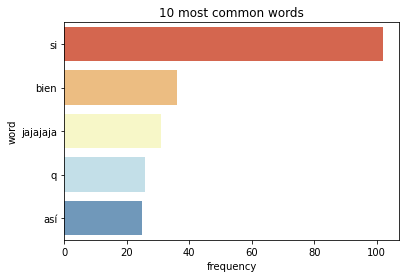

In [30]:
most_common_words = pd.DataFrame(FreqDist(all_words).most_common(5), columns=["word", "frequency"])
sns.barplot(data=most_common_words, x="frequency", y="word", orient="h", palette="RdYlBu").set(title="10 most common words");

También es necesario conocer los verbos que se emplean con frecuencia, ya que nos permitiria identificar si los relacionados con la depresión son muy frecuentes.

Este proceso se realiza mediante el objeto <code>nlp</code> de la librería <code>spacy</code>, <code>FreqDist</code> de la librería <code>nltk</code> y la función <code>barplot</code> de la librería <code>seaborn</code>.

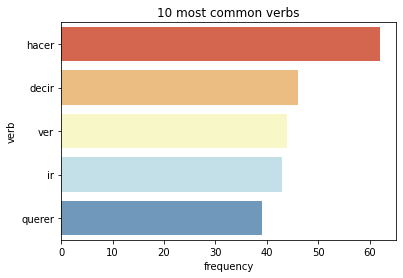

In [31]:
verbs = [item for sublist in [[token.lemma_ for token in nlp(word) if token.pos_ == "VERB"] for word in all_words] for item in sublist]
most_common_verbs = pd.DataFrame(FreqDist(verbs).most_common(5), columns=["verb", "frequency"])
sns.barplot(data=most_common_verbs, x="frequency", y="verb", orient="h", palette="RdYlBu").set(title="10 most common verbs");

Como se menciona en [[1]](https://rcs.cic.ipn.mx/2020_149_8/Identificacion%20y%20pesado%20de%20terminos%20para%20la%20deteccion%20de%20depresion%20en%20Twitter.pdf) y [[2]](https://inaoe.repositorioinstitucional.mx/jspui/bitstream/1009/1952/1/CoelloGDL.pdf), es necesario definir un diccionario de palabras que resultan relevantes.

> Dado que la mayoria de los procedimientos estadisticos para la seleccion de terminos relevantes se basa en descartar aquellas palabras con menor frecuencia, es una mejor opcion definir de forma manual el diccionario de terminos.

In [32]:
bag_of_words = {
    "words": ["problema", "lágrima", "autoestima", "error", "bullying", "hartx"],
    "verbs": ["sufrir", "olvidar", "morir", "llorar", "perder", "abandonar", "criticar", "suicidar", "ilusionar", "desilusionar", "mentir", "fingir", "desaparecer", "herir", "desahogar", "disimular", "traicionar", "fracasar", "molestar", "odiar", "sentir"],
    "feelings": ["depresión", "ansiedad", "tristeza", "desesperación", "crisis", "debilidad", "soledad", "celos", "decepción", "cansancio", "estrés", "miedo", "lástima", "dolor", "locura", "desinterés"],
    "bad_words": ["mierda", "putx", "pendejx", "idiota", "imbécil", "cabrón", "marica", "inútil", "estorbo", "estúpidx", "infeliz", "ridículx", "miserable", "malditx", "malx", "perrx"]
}

Una vez hemos creado el diccionario de terminos, es necesario conservar del conjunto de publicaciones original unicamente aquellas en las que aparezca uno o mas terminos del diccionario.

Este proceso se realiza mediante las funciones <code>apply</code> de la librería <code>pandas</code> y <code>hasWord</code>.

In [33]:
filtered_twitter_data = twitter_data[twitter_data["tweet"].apply(lambda tweet: hasWord(bag_of_words, tweet))]

Despues creamos una lista de todas los terminos contenidos en el diccionario de terminos.

In [34]:
words = [word for sublist in bag_of_words.values() for word in sublist]

Ahora empleamos la medida TF-IDF para identificar la relevancia de cada termino en aquellos documentos que contienen uno o mas terminos del diccionario de terminos.

Este proceso se realiza mediante la función <code>getTFIDF</code>.

In [35]:
scores_values = [getTFIDF(word, filtered_twitter_data["tweet"]) for word in words]
scores = pd.DataFrame({"word": words, "score": scores_values}).sort_values(by="score", ascending=False)

Ahora podemos conocer los terminos relacionados con la depresión que se usan con mayor frecuencia.

Este proceso se realiza mediante la función <code>barplot</code>.

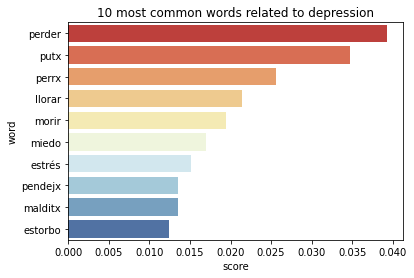

In [36]:
sns.barplot(data=scores[:10], x="score", y="word", orient="h", palette="RdYlBu").set(title="10 most common words related to depression");

## K-Means

Dado que estamos tratando con un problema de aprendizaje no supervisado, el algoritmo K-Means nos permite crear dos grupos para agrupar las publicaciones depresivas y no depresivas.

Primero, es necesario definir dos arreglos que corresponden a las variables x e y.

Este proceso se realiza mediante las funciones <code>zeros</code> de la librería <code>numpy</code> y <code>shape</code> de la librería <code>pandas</code>.

In [37]:
x = np.zeros((twitter_data.shape[0], 5))
y = np.zeros((twitter_data.shape[0], 1))

Despues, realizamos el conteo del puntaje de cada categoria de palabras depresivas que contiene cada cadena de texto.

Este proceso se realiza mediante las funciones <code>getGrammaticalPerson</code> y <code>similarityTest</code>.

In [38]:
index = 0
for tweet in twitter_data["tweet"]:
    x[index][0] = getGrammaticalPerson(tweet)
    increment = 1 if x[index][0] == 1 else 2
    index_key = 1
    for _, item in bag_of_words.items():
        x[index][index_key] = np.power(similarityTest(tweet, item, scores), increment)
        index_key += 1
    index += 1

Una vez asignados los puntajes, es necesario asegurar que no existen valores <code>NaN</code> en el arreglo <code>x</code>.

Este proceso se realiza mediante la función <code>nan_to_num</code> de la libreria <code>numpy</code>.

In [39]:
x = np.nan_to_num(x, nan=0.001)

### División: Datos de Entrenamiento y Datos de Prueba

Una vez hemos establecido los puntajes para cada publicación, procedemos a realizar la partición de los datos en datos de entrenamiento y datos de prueba.

Este proceso se realiza mediante la función <code>train_test_split</code> de la librería <code>sklearn</code>.

In [40]:
x_train, x_test, _, _ = train_test_split(x, y, train_size=0.6, random_state=8)

### Entrenamiento

Por ultimo, usaremos los datos de entrenamiento para entrenar el modelo K-Means.

Este proceso se realiza mediante el método <code>fit</code> del objeto <code>KMeans</code> de la librería <code>sklearn</code>.

In [41]:
kmeans_model = KMeans(n_clusters=2).fit(x_train)

### Prueba

Una vez que el modelo ha aprendido de los datos, es necesario usar datos de prueba para comprobar que el modelo funciona.

Este proceso se realiza mediante el método <code>predict</code> del objeto <code>KMeans</code> de la librería <code>sklearn</code>.

In [42]:
y_pred = kmeans_model.predict(x_test)

### Visualización

Es necesario visualizar la forma en la que agrupa los datos, así que graficamos las variables.

Este proceso se realiza mediante la función <code>scatterplot</code> de la librería <code>seaborn</code>.

In [43]:
test_data = pd.concat([pd.DataFrame(x_test, columns=["grammatical_person", "words", "verbs", "feelings", "bad_words"]), pd.DataFrame(y_pred, columns=["depressed"])], axis=1)

In [44]:
px.scatter_3d(test_data, x="verbs", y="feelings", z="bad_words", symbol="depressed", color="depressed", opacity=0.7, title="depression pre-diagnosis").update(layout_coloraxis_showscale=False)

In [45]:
def downloadTwitterUserData(username, path, limit):
    c = twint.Config()
    c.Username = username
    c.Limit = limit
    c.Store_csv = True
    c.Output = f"{path}/{username}.csv"
    c.Hide_output = True

    nest_asyncio.apply()
    twint.run.Search(c)
    nest_asyncio.apply(loop=None)

In [46]:
def diagnose(username, model, dictionary, path="./data", limit=10):
    # downloadTwitterUserData(username, path, limit)
    data = pd.read_csv(f"{path}/{username}.csv")[["user_id", "date", "tweet"]].astype({"date": "datetime64[ns]"})
    data["tweet"] = data["tweet"].apply(lambda tweet: removeSpecialCharacters(tweet))
    x = np.zeros((data.shape[0], 5))
    index = 0
    for tweet in data["tweet"]:
        x[index][0] = getGrammaticalPerson(tweet)
        increment = 1 if x[index][0] == 1 else 2
        index_key = 1
        for _, item in dictionary.items():
            x[index][index_key] = np.power(similarityTest(tweet, item, scores), increment)
            index_key += 1
        index += 1
    x = np.nan_to_num(x, nan=0.001)
    y = model.predict(x)
    return pd.concat([data, pd.DataFrame(y, columns=["depressed"])], axis=1)

In [47]:
df = diagnose("gbrends_10", kmeans_model, bag_of_words, limit=1000)

In [48]:
df[df["depressed"] == 1]

,user_id,date,tweet,depressed
0,2167266710,2021-06-15,quítenle el monstruo pero pobre cosita c hoy s...,1
1,2167266710,2021-06-14,uff estaba esperando este momento,1
2,2167266710,2021-06-13,xd,1
3,2167266710,2021-06-12,la gente hoy en día es como wow que tipa tan i...,1
4,2167266710,2021-06-12,,1
...,...,...,...,...
92,2167266710,2020-11-11,chale me toca llorando y rankeando en lol un d...,1
93,2167266710,2020-10-29,que puto desgaste decirle a alguien que deje d...,1
94,2167266710,2020-10-25,,1
97,2167266710,2020-10-20,hazlo yo te apoyo,1


In [49]:
#from sklearn.metrics import confusion_matrix

# y_pred = df[df["depressed"] == 1]["depressed"]
# y_true = []
# confusion_matrix(y_true, y_pred)

In [50]:
# Xtreme KFold
# Scores

## Referencias

1. https://rcs.cic.ipn.mx/2020_149_8/Identificacion%20y%20pesado%20de%20terminos%20para%20la%20deteccion%20de%20depresion%20en%20Twitter.pdf
2. https://inaoe.repositorioinstitucional.mx/jspui/bitstream/1009/1952/1/CoelloGDL.pdf